In [1]:
import pandas as pd
import os
os.chdir("/media/seconddrive/mta_stationing_problem")
import gtfs_kit as gk
from pyspark import SparkContext,SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import Row, SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from pyspark import SparkConf
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import osmnx as ox
import geopandas as gpd
import pickle
import numpy as np
from tqdm import tqdm
from src import data_utils, triplevel_utils
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

pd.set_option('display.max_columns', None)
spark = SparkSession.builder.master("local[*]")\
                                    .config("spark.sql.session.timeZone", "UTC")\
                                    .config('spark.driver.extraJavaOptions', '-Duser.timezone=UTC')\
                                    .config('spark.driver.memory', '2g')\
                                    .config('spark.executor.memory', '2g')\
                                    .config("spark.ui.showConsoleProgress", "false")\
                                    .appName("app").getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

/home/jptalusan/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


22/09/06 17:55:01 WARN Utils: Your hostname, scope-vanderbilt resolves to a loopback address: 127.0.1.1; using 10.2.218.69 instead (on interface enp8s0)
22/09/06 17:55:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/06 17:55:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/06 17:55:02 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [7]:
filepath = os.path.join("data", "weather", "darksky_nashville_20220406.csv")
darksky = pd.read_csv(filepath)
# GMT-5
darksky['datetime'] = darksky['time'] - 18000
darksky['datetime'] = pd.to_datetime(darksky['datetime'], infer_datetime_format=True, unit='s')
darksky = darksky.set_index(darksky['datetime'])
# darksky = darksky.sort_index().loc[date_range[0]:date_range[1]]
darksky['year'] = darksky['datetime'].dt.year
darksky['month'] = darksky['datetime'].dt.month
darksky['day'] = darksky['datetime'].dt.day
darksky['hour'] = darksky['datetime'].dt.hour
val_cols= ['temperature', 'humidity', 'nearest_storm_distance', 'precipitation_intensity', 'precipitation_probability', 'pressure', 'wind_gust', 'wind_speed']
join_cols = ['year', 'month', 'day', 'hour']
darksky = darksky[val_cols+join_cols]
renamed_cols = {k: f"darksky_{k}" for k in val_cols}
darksky = darksky.rename(columns=renamed_cols)
darksky = darksky.groupby(['year', 'month', 'day', 'hour']).mean().reset_index()
darksky=spark.createDataFrame(darksky)
darksky.createOrReplaceTempView("darksky")

In [9]:
# Get service disruption dataset
fp = os.path.join('data', 'others', 'Service Disruptions_07_2019_08_2022.csv')
disruptions_df = pd.read_csv(fp)
disruptions_df.head()
disruptions_df['DATETIME'] = disruptions_df['DATE'] + ' ' + disruptions_df['TIME']
disruptions_df['DATE'] = pd.to_datetime(disruptions_df['DATE'], format='%m/%d/%y', errors='coerce')
disruptions_df['TIME'] = pd.to_datetime(disruptions_df['TIME'], format='%H:%M:%S', errors='coerce')
disruptions_df['DATETIME'] = pd.to_datetime(disruptions_df['DATETIME'], format='%m/%d/%y %H:%M:%S', errors='coerce')

# Remove weather related disruptions
# disruptions_df = disruptions_df[(disruptions_df['REASON'] != 'Weather')].sort_values(by=['DATETIME']).reset_index(drop=True)
print('Shape:', disruptions_df.shape)
# disruptions_df = disruptions_df.drop(columns=['COMMENTS'])
disruptions_df['BLOCK'] = disruptions_df['BLOCK'].astype('int32')

# Convert to spark dataframe for merging
# disruptions_sp = disruptions_sp.withColumn("BLOCK", F.col("BLOCK").cast(IntegerType()))

disruptions_df['year'] = disruptions_df['DATETIME'].dt.year
disruptions_df['month'] = disruptions_df['DATETIME'].dt.month
disruptions_df['day'] = disruptions_df['DATETIME'].dt.day
disruptions_df['hour'] = disruptions_df['DATETIME'].dt.hour

disruptions_sp = spark.createDataFrame(disruptions_df)

Shape: (5066, 10)


In [10]:

# join apc and darksky
disruptions_sp = disruptions_sp.join(darksky,on=['year', 'month', 'day', 'hour'], how='left')

In [12]:
# load weatherbit
filepath = os.path.join("data", "weather", "weatherbit_weather_2010_2022.parquet")
weatherbit = spark.read.load(filepath)

weatherbit = weatherbit.filter("(spatial_id = 'Berry Hill') OR (spatial_id = 'Belle Meade')")
weatherbit.createOrReplaceTempView("weatherbit")
query = f"""
SELECT *
FROM weatherbit
"""
weatherbit = spark.sql(query)

weatherbit = weatherbit.withColumn('year', F.year(weatherbit.timestamp_local))
weatherbit = weatherbit.withColumn('month', F.month(weatherbit.timestamp_local))
weatherbit = weatherbit.withColumn('day', F.dayofmonth(weatherbit.timestamp_local))
weatherbit = weatherbit.withColumn('hour', F.hour(weatherbit.timestamp_local))
weatherbit = weatherbit.select('year', 'month', 'day', 'hour', 'rh', 'wind_spd', 'slp', 'app_temp', 'temp', 'snow', 'precip')
weatherbit = weatherbit.groupBy('year', 'month', 'day', 'hour').agg(F.mean('rh').alias('weatherbit_rh'), \
                                                                    F.mean('wind_spd').alias('weatherbit_wind_spd'), \
                                                                    F.mean('app_temp').alias('weatherbit_app_temp'), \
                                                                    F.mean('temp').alias('weatherbit_temp'), \
                                                                    F.mean('snow').alias('weatherbit_snow'), \
                                                                    F.mean('precip').alias('weatherbit_precip')
                                                                   )
weatherbit = weatherbit.sort(['year', 'month', 'day', 'hour'])

# join apc and weatherbit
disruptions_sp = disruptions_sp.join(weatherbit,on=['year', 'month', 'day', 'hour'], how='left')

In [13]:
disruptions_df = disruptions_sp.toPandas()

<AxesSubplot:>

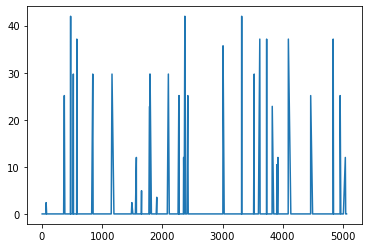

In [18]:
disruptions_df.query("month == 1")['weatherbit_snow'].plot()

<AxesSubplot:>

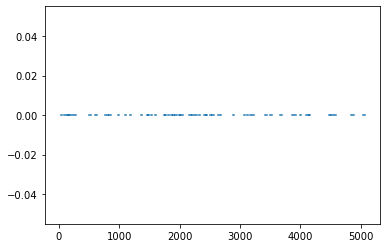

In [17]:
disruptions_df.query("month == 7")['weatherbit_snow'].plot()

In [22]:
disruptions_df.shape

(5066, 28)

In [24]:
fp = 'data/processed/service_disruptions_with_weather.pkl'
disruptions_df.to_pickle(fp)